# 80s Metal

## segmentation of concerts

Scott Harrison - 2019-04-07

Segments a band´s concerts to see what can de understood from when and where they have played.

### set up

In [95]:
import pandas as pd
import numpy as np
import geopandas
import os
import pickle
import matplotlib.pyplot as plt  
import matplotlib.cm as cm
%matplotlib inline
from sklearn.cluster import KMeans  
from haversine import haversine
from datetime import datetime
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_samples, silhouette_score

dir_repo = "C:\\Users\\harri\\Dropbox\\01 Scott\\Data Science\\Repositories\\"
dir_proj = dir_repo + "\\80s-metal\\segmentation-of-concerts\\"
data_concert = dir_proj + "data\\motley_crue-concerts.xlsx"
data_name = 'motley_crue-concerts'

os.getcwd()
os.chdir(dir_proj)
os.getcwd()


'C:\\Users\\harri\\Dropbox\\01 Scott\\Data Science\\Repositories\\80s-metal\\segmentation-of-concerts'

### data prep

In [363]:
# read in the data
df = pd.read_excel(data_concert)

# update names
df.columns = [x.strip().lower() for x in df.columns.values.tolist()]

# summarise results
print(df.head())
print(df.describe())
print(df.columns)
print(type(df))

           date                         concert                         venue  \
0  Jan 10, 2019                     Motley crue  Molson Canadian Amphitheatre   
1  May 22, 2018                     Motley Crue                           NaN   
2  Jan 09, 2017  Alice cooper and motley CrÃ¼e                Rod Laver Arena   
3           NaN      Alice Cooper / Motley Crue                           NaN   
4  Jan 04, 2017                     Motley Crue                           NaN   

                  location  
0  Toronto Ontario, Canada  
1                      NaN  
2                Melbourne  
3                      NaN  
4                      NaN  
                date        concert           venue     location
count            510            715             476          471
unique           386            330             273          198
top     Jun 12, 2015  Motley Crue    Donington Park  Houston, TX
freq               8             64              11           13
Index(['date',

In [364]:
# consolidate rows
df['id'] = df.index
df_new = df[pd.notnull(df['date'])]
df_add1 = df[pd.isnull(df['date'])][['concert', 'id']]
df_add2 = df[pd.isnull(df['venue'])][['concert', 'id']]
df_add3 = df[pd.isnull(df['location'])][['concert', 'id']]
df_add = pd.merge(df_add2, df_add3)
df_add = pd.merge(df_add1, df_add, how='outer')
df_add['id'] = df_add['id'] - 1
df_comb = pd.merge(df_new, df_add, how='left', on='id')
df_comb = df_comb[pd.notnull(df_comb['location'])]
df = df_comb[['date', 'concert_x', 'concert_y', 'venue', 'location']].copy()
df = df.fillna('')
df.head(60)

,date,concert_x,concert_y,venue,location
0,"Jan 10, 2019",Motley crue,Motley Crue,Molson Canadian Amphitheatre,"Toronto Ontario, Canada"
2,"Jan 09, 2017",Alice cooper and motley CrÃ¼e,Alice Cooper / Motley Crue,Rod Laver Arena,Melbourne
4,"Dec 15, 2016",Motley Crue,,Arena,"Lexington, KY"
6,"May 19, 2016",Motley CrÃ¼e The Final Tour,Motley Crue,Brisbane Entertainment Centre,"Brisbane, QLD"
7,"Dec 31, 2015",Motley Crue,,Staples Center,"Los Angeles, CA"
8,"Dec 19, 2015",Motley Crue / Alice Cooper,,US Airways Center,"Phoenix, AZ"
9,"Dec 15, 2015",The Final Tour,Motley Crue / Alice Cooper,Moda Center,"Portland, OR"
10,"Dec 15, 2015",Motley Crue,,Moda Center,"Portland, OR"
11,"Dec 08, 2015",Motley Crue / Alice Cooper,,Target Center,"Minneapolis, MN"
12,"Dec 04, 2015",Motley Crue / Alice Cooper,,Pinnacle Bank Arena,"Lincoln, NE"


In [365]:
# create dates and select valid
df_dates = df.copy()
df_dates['date'] = pd.to_datetime(df_dates['date'].str[0:12], infer_datetime_format=True)
df_dates['year'] = df_dates['date'].dt.year
df_dates['month'] = df_dates['date'].dt.month
df_dates['day'] = df_dates['date'].dt.dayofweek
df_dates['isweekend'] = df_dates['day'] > 4
df_dates = df_dates[df_dates['date'].dt.year <= 2015]
df = df_dates
print(df.head())
print(df.shape)

         date                         concert_x                   concert_y  \
7  2015-12-31                     Motley Crue                                 
8  2015-12-19  Motley Crue / Alice Cooper                                     
9  2015-12-15                  The Final Tour    Motley Crue / Alice Cooper   
10 2015-12-15                     Motley Crue                                 
11 2015-12-08      Motley Crue / Alice Cooper                                 

                venue         location  year  month  day  isweekend  
7      Staples Center  Los Angeles, CA  2015     12    3      False  
8   US Airways Center      Phoenix, AZ  2015     12    5       True  
9         Moda Center     Portland, OR  2015     12    1      False  
10        Moda Center     Portland, OR  2015     12    1      False  
11      Target Center  Minneapolis, MN  2015     12    1      False  
(467, 9)


In [366]:
# remove duplicates
df.sort_values(['date'], inplace = True) 
df.drop_duplicates(subset =['date'], keep='first', inplace=True) 
print(df.head())
print(df.shape)

          date                                          concert_x  \
509 1982-12-31  Motley Crue / Nisan "The Gypsy" & The Star Of ...   
508 1983-03-27                           KISS / Motley Crue         
507 1983-05-25                                       Us festival    
505 1983-05-28                                 US Festival 1983     
504 1983-05-29                               US FESTIVAL 83         

                                             concert_y  \
509                                                      
508                                                      
507                                        Motley Crue   
505                                                      
504  Van Halen / Scorpions / Triumph / Judas Priest...   

                                           venue            location  year  \
509                Santa Monica Civic Auditorium    Santa Monica, CA  1982   
508                       Universal Amphitheatre  Universal City, CA  1983   
50

### data augmentation

In [375]:
# get lat and long from OpenStreetMap
from geopy.exc import GeocoderTimedOut

def do_geocode(address):
    try:
        return geopandas.tools.geocode(address)
    except GeocoderTimedOut:
        return do_geocode(address)
    
def geocode_smh(address, location):
    try:
        geo = geopandas.tools.geocode(address, provider="nominatim")
    except TypeError:
        try:
            geo = geopandas.tools.geocode(location, provider="nominatim")
        except TypeError:
            print('ERROR')
        except GeocoderTimedOut:
            geocode_smh(address, location)
        else:
            return(geo)
    except GeocoderTimedOut:
        geocode_smh(address, location)
    else:
        return(geo)

df_geo = df[df.index < 2000].copy()
df_geo.index = range(df_geo.shape[0])
df_det = pd.DataFrame() #geocode_smh('Sydney, NSW', 'Sydney, NSW')

for i in range(0, df_geo.shape[0]):
    df_tmp = df_geo[df_geo.index == i].copy()
    df_tmp['address_orig'] = df_tmp['venue'] + ', ' + df_tmp['location']
    print(i, df_tmp['address_orig'].to_string())
    df_new = geocode_smh(df_tmp['address_orig'], df_tmp['location'])
    try:
        x_new = df_new.geometry.x
    except AttributeError:
        a = 1
        #df_new['longitude'] = np.NaN
    else:
        df_new['longitude'] = x_new
    try:
        y_new = df_new.geometry.y
    except AttributeError:
        a = 1
        #df_new['latitude'] = np.NaN
    else:#
        df_new['latitude'] = y_new
    df_det = pd.concat([df_det, df_new])

df_geo = pd.merge(df_geo, df_det, how='left', left_index=True, right_index=True)
print(type(df_geo))
df_geo.head()

0 0    Santa Monica Civic Auditorium, Santa Monica, CA
1 1    Universal Amphitheatre, Universal City, CA
2 2    Glen Helen Amphitheater, Devore, CA
3 3    Glen Helen Amphitheater, San Bernardino, CA
4 4    Glen Helen Regional Park & Festival Grounds, S...
5 5    5 seasons center, cedar rapids iowa
6 6    Fox Theatre, San Diego, CA
7 7    Santa Monica Civic Auditorium, Santa Monica, CA
8 8    The Astroarena, Houston, TX
9 9    Broome County Arena, Binghamton, NY
10 10    Stabler Arena, Lehigh University, Bethlehem, PA
11 11    The Arena, St. Louis, MO
12 12    The Summit, Houston, TX
13 13    Mecca Arena, Milwaukee, WI
14 14    Civic Auditorium, Omaha, NE
15 15    The Salt Palace, Salt Lake City, UT
16 16    Pacific Coliseum, Vancouver, BC
17 17    Memorial Coliseum , Portland, OR
18 18    Onondaga War Memorial, Syracuse, NY
19 19    Roberts Stadium, Evansville, IN
20 20    Aragon Ballroom, Chicago, IL
21 21    Orpheum Theatre, Boston, MA
22 22    City Island, Harrisburg, PA
23 23    Ca

,date,concert_x,concert_y,venue,location,year,month,day,isweekend,geometry,address,longitude,latitude
0,1982-12-31,"Motley Crue / Nisan ""The Gypsy"" & The Star Of ...",,Santa Monica Civic Auditorium,"Santa Monica, CA",1982,12,4,False,POINT (-118.489305241662 34.0090592),"Santa Monica Civic Auditorium, Pico Boulevard,...",-118.489305,34.009059
1,1983-03-27,KISS / Motley Crue,,Universal Amphitheatre,"Universal City, CA",1983,3,6,True,POINT (-118.3584364 34.1412926),"Universal City, Hollywood Hills, LA, Los Angel...",-118.358436,34.141293
2,1983-05-25,Us festival,Motley Crue,Glen Helen Amphitheater,"Devore, CA",1983,5,2,False,POINT (-117.4014365 34.2163964),"Devore, San Bernardino County, California, USA",-117.401437,34.216396
3,1983-05-28,US Festival 1983,,Glen Helen Amphitheater,"San Bernardino, CA",1983,5,5,True,POINT (-117.2897652 34.1083449),"San Bernardino, San Bernardino County, Califor...",-117.289765,34.108345
4,1983-05-29,US FESTIVAL 83,Van Halen / Scorpions / Triumph / Judas Priest...,Glen Helen Regional Park & Festival Grounds,"San Bernardino, CA",1983,5,6,True,POINT (-117.2897652 34.1083449),"San Bernardino, San Bernardino County, Califor...",-117.289765,34.108345


In [376]:
# save the geocoded data
fileObject = open('.//data//'+data_name, 'wb') 
pickle.dump(df_geo,fileObject)   
fileObject.close()

### segmentation

In [2]:
# read in data
with open('.//data//'+data_name, 'rb') as fileObject:
    df = pickle.load(fileObject)
    
# remove duplicates
df.sort_values(['date'], inplace = True) 
df.drop_duplicates(subset =['date'], keep='first', inplace=True) 
print(df.head())
print(df.shape)

        date                                          concert_x  \
0 1982-12-31  Motley Crue / Nisan "The Gypsy" & The Star Of ...   
1 1983-03-27                           KISS / Motley Crue         
2 1983-05-25                                       Us festival    
3 1983-05-28                                 US Festival 1983     
4 1983-05-29                               US FESTIVAL 83         

                                           concert_y  \
0                                                      
1                                                      
2                                        Motley Crue   
3                                                      
4  Van Halen / Scorpions / Triumph / Judas Priest...   

                                         venue            location  year  \
0                Santa Monica Civic Auditorium    Santa Monica, CA  1982   
1                       Universal Amphitheatre  Universal City, CA  1983   
2                      Glen Hele

In [22]:
# calculate distance from Whisky-a-Go-Go
origin = geopandas.tools.geocode('Whisky a Go Go, West Hollywood, LA', provider="nominatim")
orig_lon = origin.geometry.x
orig_lat = origin.geometry.y
df['distance'] = df.apply(lambda x: haversine((orig_lat, orig_lon),(x['latitude'], x['longitude'])), axis=1)
df.head()

,date,concert_x,concert_y,venue,location,year,month,day,isweekend,geometry,address,longitude,latitude,distance
0,1982-12-31,"Motley Crue / Nisan ""The Gypsy"" & The Star Of ...",,Santa Monica Civic Auditorium,"Santa Monica, CA",1982,12,4,False,POINT (-118.489305241662 34.0090592),"Santa Monica Civic Auditorium, Pico Boulevard,...",-118.489305,34.009059,13.183992
1,1983-03-27,KISS / Motley Crue,,Universal Amphitheatre,"Universal City, CA",1983,3,6,True,POINT (-118.3584364 34.1412926),"Universal City, Hollywood Hills, LA, Los Angel...",-118.358436,34.141293,6.144694
2,1983-05-25,Us festival,Motley Crue,Glen Helen Amphitheater,"Devore, CA",1983,5,2,False,POINT (-117.4014365 34.2163964),"Devore, San Bernardino County, California, USA",-117.401437,34.216396,91.639957
3,1983-05-28,US Festival 1983,,Glen Helen Amphitheater,"San Bernardino, CA",1983,5,5,True,POINT (-117.2897652 34.1083449),"San Bernardino, San Bernardino County, Califor...",-117.289765,34.108345,100.929369
4,1983-05-29,US FESTIVAL 83,Van Halen / Scorpions / Triumph / Judas Priest...,Glen Helen Regional Park & Festival Grounds,"San Bernardino, CA",1983,5,6,True,POINT (-117.2897652 34.1083449),"San Bernardino, San Bernardino County, Califor...",-117.289765,34.108345,100.929369


In [106]:
# create numpy array
df['days_since_1980'] = (df['date'] - datetime(1980, 1, 1)).dt.days
df = df[df['latitude'].notnull()]
#X_raw = np.array(df[['days_since_1980', 'year', 'day', 'isweekend', 'latitude', 'longitude', 'distance']])
X_raw = np.array(df[['days_since_1980', 'latitude', 'longitude']])
X_raw

array([[ 1095.        ,    34.0090592 ,  -118.48930524],
       [ 1181.        ,    34.1412926 ,  -118.3584364 ],
       [ 1240.        ,    34.2163964 ,  -117.4014365 ],
       ...,
       [13132.        ,    45.53161025,  -122.66684435],
       [13136.        ,    33.4460392 ,  -112.0711013 ],
       [13148.        ,    34.0430046 ,  -118.2670526 ]])

In [107]:
# normalise array
X = normalize(X_raw, axis=0, norm='max')
X

array([[ 0.08328263,  0.56520381, -0.78357416],
       [ 0.08982355,  0.56740143, -0.78270872],
       [ 0.09431092,  0.56864959, -0.77638004],
       ...,
       [ 0.99878308,  0.75669954, -0.81120038],
       [ 0.99908731,  0.55584686, -0.74113034],
       [ 1.        ,  0.56576796, -0.78210439]])

In [111]:
# segment
for k in range(2,20):
    clusterer = KMeans(n_clusters=k)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", k, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.770093448572327
For n_clusters = 3 The average silhouette_score is : 0.5155262801530852
For n_clusters = 4 The average silhouette_score is : 0.55132923773784
For n_clusters = 5 The average silhouette_score is : 0.4030740090275502
For n_clusters = 6 The average silhouette_score is : 0.4111005493019353
For n_clusters = 7 The average silhouette_score is : 0.4487829180682575
For n_clusters = 8 The average silhouette_score is : 0.3868750955159673
For n_clusters = 9 The average silhouette_score is : 0.3750476449542438
For n_clusters = 10 The average silhouette_score is : 0.39781736692533487
For n_clusters = 11 The average silhouette_score is : 0.38139647225759526
For n_clusters = 12 The average silhouette_score is : 0.3857680940900137
For n_clusters = 13 The average silhouette_score is : 0.3929019821775848
For n_clusters = 14 The average silhouette_score is : 0.3978941971248853
For n_clusters = 15 The average silhouette_score is : 0.3939

In [112]:
# create final segments
clusterer = KMeans(n_clusters=4)
df['cluster'] = clusterer.fit_predict(X)
df.head()

,date,concert_x,concert_y,venue,location,year,month,day,isweekend,geometry,address,longitude,latitude,distance,days_since_1980,cluster
0,1982-12-31,"Motley Crue / Nisan ""The Gypsy"" & The Star Of ...",,Santa Monica Civic Auditorium,"Santa Monica, CA",1982,12,4,False,POINT (-118.489305241662 34.0090592),"Santa Monica Civic Auditorium, Pico Boulevard,...",-118.489305,34.009059,13.183992,1095,0
1,1983-03-27,KISS / Motley Crue,,Universal Amphitheatre,"Universal City, CA",1983,3,6,True,POINT (-118.3584364 34.1412926),"Universal City, Hollywood Hills, LA, Los Angel...",-118.358436,34.141293,6.144694,1181,0
2,1983-05-25,Us festival,Motley Crue,Glen Helen Amphitheater,"Devore, CA",1983,5,2,False,POINT (-117.4014365 34.2163964),"Devore, San Bernardino County, California, USA",-117.401437,34.216396,91.639957,1240,0
3,1983-05-28,US Festival 1983,,Glen Helen Amphitheater,"San Bernardino, CA",1983,5,5,True,POINT (-117.2897652 34.1083449),"San Bernardino, San Bernardino County, Califor...",-117.289765,34.108345,100.929369,1243,0
4,1983-05-29,US FESTIVAL 83,Van Halen / Scorpions / Triumph / Judas Priest...,Glen Helen Regional Park & Festival Grounds,"San Bernardino, CA",1983,5,6,True,POINT (-117.2897652 34.1083449),"San Bernardino, San Bernardino County, Califor...",-117.289765,34.108345,100.929369,1244,0


### profiling

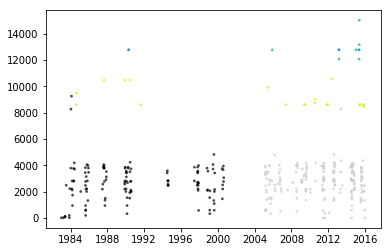

In [113]:
# view segments
colors = cm.nipy_spectral(df['cluster'].astype(float) / 3)
plt.scatter(df['date'], df['distance'], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

In [114]:
# summarise by segment
df

,date,concert_x,concert_y,venue,location,year,month,day,isweekend,geometry,address,longitude,latitude,distance,days_since_1980,cluster
0,1982-12-31,"Motley Crue / Nisan ""The Gypsy"" & The Star Of ...",,Santa Monica Civic Auditorium,"Santa Monica, CA",1982,12,4,False,POINT (-118.489305241662 34.0090592),"Santa Monica Civic Auditorium, Pico Boulevard,...",-118.489305,34.009059,13.183992,1095,0
1,1983-03-27,KISS / Motley Crue,,Universal Amphitheatre,"Universal City, CA",1983,3,6,True,POINT (-118.3584364 34.1412926),"Universal City, Hollywood Hills, LA, Los Angel...",-118.358436,34.141293,6.144694,1181,0
2,1983-05-25,Us festival,Motley Crue,Glen Helen Amphitheater,"Devore, CA",1983,5,2,False,POINT (-117.4014365 34.2163964),"Devore, San Bernardino County, California, USA",-117.401437,34.216396,91.639957,1240,0
3,1983-05-28,US Festival 1983,,Glen Helen Amphitheater,"San Bernardino, CA",1983,5,5,True,POINT (-117.2897652 34.1083449),"San Bernardino, San Bernardino County, Califor...",-117.289765,34.108345,100.929369,1243,0
4,1983-05-29,US FESTIVAL 83,Van Halen / Scorpions / Triumph / Judas Priest...,Glen Helen Regional Park & Festival Grounds,"San Bernardino, CA",1983,5,6,True,POINT (-117.2897652 34.1083449),"San Bernardino, San Bernardino County, Califor...",-117.289765,34.108345,100.929369,1244,0
5,1983-07-13,Motley Crue,,5 seasons center,cedar rapids iowa,1983,7,2,False,POINT (-91.6704053 41.9758872),"Cedar Rapids, Iowa, USA",-91.670405,41.975887,2486.125945,1289,0
6,1983-11-13,Shout at the Devil Tour,,Fox Theatre,"San Diego, CA",1983,11,6,True,POINT (-117.1627714 32.7174209),"San Diego, San Diego County, California, USA",-117.162771,32.717421,190.285850,1412,0
7,1983-11-16,Motley Crue / Axe,,Santa Monica Civic Auditorium,"Santa Monica, CA",1983,11,2,False,POINT (-118.489305241662 34.0090592),"Santa Monica Civic Auditorium, Pico Boulevard,...",-118.489305,34.009059,13.183992,1415,0
8,1983-12-02,Too Fast for Love,Motley Crue / Axe / Heaven,The Astroarena,"Houston, TX",1983,12,4,False,POINT (-95.3676974 29.7589382),"Houston, Harris County, Texas, USA",-95.367697,29.758938,2219.978535,1431,0
9,1984-01-13,Ozzy Osbourne / Motley Crue,,Broome County Arena,"Binghamton, NY",1984,1,4,False,POINT (-75.91434099999999 42.096968),"Binghamton, Broome County, New York, USA",-75.914341,42.096968,3780.850731,1473,0
